## Notebook Overview

This notebook builds upon the insights gained from the previous notebook (`03_exploratory_data_analysis.ipynb`) and focuses on **Feature Engineering**. This stage involves creating new features and transforming existing ones based on our statistical findings and domain knowledge to Improve our credit risk model.

### 0.4.1 Objectives

The main objectives of this notebook are:

1. **Leverage EDA Insights:** Utilize the patterns and relationships uncovered in our exploratory data analysis to guide our feature engineering efforts.
2. **Create Non-Linear Transformations:** Develop binned versions of continuous variables to capture non-linear relationships with the target variable.
3. **Implement Domain-Specific Features:** Create new features based on financial domain knowledge that are known to be relevant in credit risk assessment.
4. **Improve Model Input:** Generate features that can potentially improve our model's predictive power and interpretability.
5. **Prepare for Modeling:** Finalize the feature set that will be used in our subsequent modeling efforts.

### 0.4.2 Importance of Feature Engineering

Feature engineering plays a crucial role in improving machine learning model performance:

- **Capture Complex Relationships:** Engineered features can help models capture non-linear and intricate relationships that may not be apparent in the raw data.
- **Incorporate Domain Knowledge:** It allows us to inject domain expertise into our data, potentially improving model performance and interpretability.
- **Improve Model Generalization:** Well-engineered features can help models generalize better to unseen data.
- **Improve Interpretability:** Carefully crafted features can make model predictions more understandable and actionable for stakeholders.

### 0.4.3 Our Approach

In this notebook, we will focus on the following feature engineering tasks:

1. **Age Binning:** Create age groups (18-25, 26-35, 36-45, 46-55, 56-65, 65+) to capture non-linear relationships with default risk.
2. **Financial Ratios:** Implement key financial ratios including:
   - Debt-to-income ratio
   - Credit-to-goods price ratio
   - Annuity-to-income ratio
3. **Stability Indicators:** Derive new features such as:
   - Employed-to-age ratio
   - Flag for when credit amount exceeds goods price
4. **Credit Score Aggregation:** Generate an average of external source scores for a more stable overall credit score indicator.
5. **Income and Credit Amount Binning:** Create bins for income and credit amount variables to identify potential threshold effects and improve model robustness to outliers.

By the end of this notebook, we will have a rich set of engineered features that leverage both our data-driven insights and domain knowledge, setting a strong foundation for our subsequent modeling efforts.

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd
from IPython.display import Image

import warnings

from retail_bank_risk.feature_engineering_utils import (
    create_binned_features,
    create_derived_features,
    encode_categorical_features,
)

from retail_bank_risk.basic_visualizations_utils import (
    plot_combined_histograms,
    plot_categorical_features_by_target,
)

warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
application_train = pd.read_parquet(
    "../data/processed/application_train_prepared.parquet"
)
application_test = pd.read_parquet(
    "../data/processed/application_test_prepared.parquet"
)

We will use the `create_binned_features` function to transform continuous numerical variables into categorical bins, simplifying the dataset.4

This function will bin the `days_birth` column into predefined age groups, converting age (expressed in days) into meaningful categories like "18-25" and "65+".

We will also use it to bin the `amt_income_total` and `amt_credit` columns into quantile-based groups, ensuring approximately equal representation in each bin.

This binning will help mitigate the impact of outliers and capture non-linear relationships between these variables and the target variable.

Ultimately, this process will enhance model interpretability and stability by grouping continuous data into manageable segments.


In [21]:
application_train_engineered = create_binned_features(application_train)
application_test_engineered = create_binned_features(application_test)

After binning the data, we will apply one-hot encoding to the categorical features. Features with more than two categories will be encoded separately. We will also separate the target variable from the encoded features.

In [22]:
# Loop through each feature and print the feature name along with its unique values
for feature in application_train_engineered.columns:
    unique_values = application_train_engineered[feature].unique()
    print(f"Feature: {feature}")
    print(f"Unique Values: {unique_values}")
    print("\n")  # Adds a new line for better readability between features


Feature: reg_city_not_work_city
Unique Values: ['0', '1']
Categories (2, object): ['0', '1']


Feature: region_rating_client_w_city
Unique Values: ['2', '1', '3']
Categories (3, object): ['2', '1', '3']


Feature: region_rating_client
Unique Values: ['2', '1', '3']
Categories (3, object): ['2', '1', '3']


Feature: name_contract_type
Unique Values: ['Cash loans', 'Revolving loans']
Categories (2, object): ['Cash loans', 'Revolving loans']


Feature: code_gender
Unique Values: ['M', 'F', 'XNA']
Categories (3, object): ['M', 'F', 'XNA']


Feature: flag_own_car
Unique Values: ['N', 'Y']
Categories (2, object): ['N', 'Y']


Feature: flag_own_realty
Unique Values: ['Y', 'N']
Categories (2, object): ['Y', 'N']


Feature: name_type_suite
Unique Values: ['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', 'mode', 'Other_B', 'Group of people']
Categories (8, object): ['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', 'Other_B', 'Group of people', 'mode']


Fe

In [23]:
ohe_features = [
    "reg_city_not_work_city",  # Binary, 2 distinct values
    "name_contract_type",  # Binary, 2 distinct values
    "code_gender",  # Binary, 2 distinct values
    "flag_own_car",  # Binary, 2 distinct values
    "flag_own_realty",  # Binary, 2 distinct values
    "name_type_suite",  # 8 distinct values
    "name_income_type",  # 8 distinct values
    "name_family_status",  # 6 distinct values
    "name_housing_type",  # 6 distinct values
    "weekday_appr_process_start",  # 7 distinct values
    "housetype_mode",  # 4 distinct values
    "emergencystate_mode",  # 3 distinct values
    "is_anomaly",  # Binary, 2 distinct values
]

ordinal_features = [
    "region_rating_client", # 3 distinct values
    "region_rating_client_w_city", # 3 distinct values
    "name_education_type", # 5 distinct values
    "age_group", # 6 distinct values
    "income_group", # 5 distinct values
    "credit_amount_group" # distinct values
]

ordinal_orders = {
    "region_rating_client": ['3', '2', '1'],  # 1 is best, 3 is worst
    "region_rating_client_w_city": ['3', '2', '1'],  # 1 is best, 3 is worst
    "name_education_type": [
        "Lower secondary",
        "Secondary / secondary special",
        "Incomplete higher",
        "Higher education",
        "Academic degree"
    ],
    "age_group": ['18-25', '26-35', '36-45', '46-55', '56-65', '65+'],
    "income_group": ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
    "credit_amount_group": ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
}

target_encoded_features = [
    "occupation_type",  # 19 distinct values
    "organization_type",  # 58 distinct values
]

target_feature = "target"  # Binary target with 0 and 1 values

We will now generate new features using the `create_derived_features` function.

This function will calculate key financial ratios, including `debt_to_income_ratio`, `credit_to_goods_ratio`, and `annuity_to_income_ratio`, to provide insights into applicants' financial health.

We will also create `ext_source_mean` by averaging external source scores for a consolidated measure of external assessments.

Furthermore, we will generate a binary flag, `credit_exceeds_goods`, to indicate instances where the credit amount surpasses the value of the goods purchased.

These derived features will improve the dataset's predictive power by capturing important financial relationships.


In [24]:
application_train_engineered = create_derived_features(application_train_engineered)
application_test_engineered = create_derived_features(application_test_engineered)

Next we will check the distributions of our newly engineered features.

In [25]:
numerical_features = [
    'debt_to_income_ratio',
    'credit_to_goods_ratio',
    'annuity_to_income_ratio',
    'ext_source_mean'
]

In [26]:
plot_combined_histograms(application_train_engineered, numerical_features, nbins=40, save_path="../images/numerical_features_engineered.png")

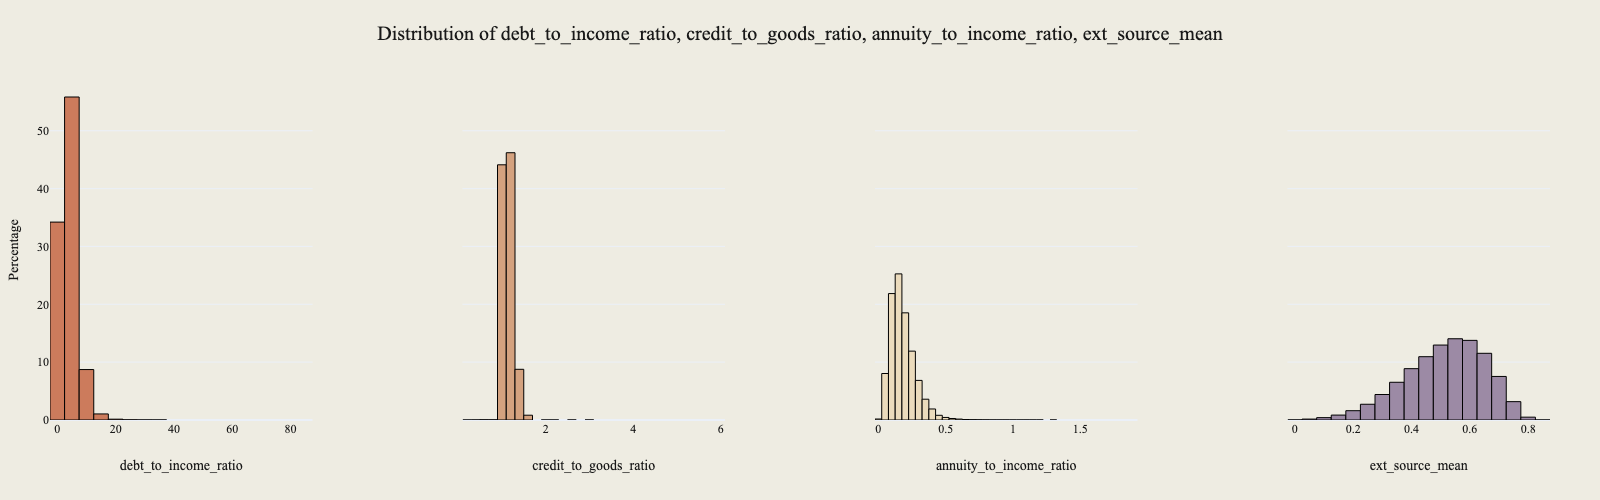

In [27]:
Image(filename="../images/numerical_features_engineered.png")

- **debt_to_income_ratio:** Heavily right-skewed distribution with a sharp peak near zero. This suggests most applicants have relatively low debt compared to their income, but there are some outliers with very high ratios.

- **credit_to_goods_ratio:** Bimodal distribution with peaks around 1 and 2. This indicates two common scenarios: loans roughly equal to the goods' price, and loans about twice the goods' price.

- **annuity_to_income_ratio:** Right-skewed distribution with a peak around 0.1-0.2. This implies most applicants have annual loan payments that are 10-20% of their income, with some having higher ratios.

- **ext_source_mean:** Roughly normal distribution with a slight left skew, centered around 0.5. This suggests a balanced spread of external source scores, with a slight tendency towards higher scores.

In [28]:
application_train_engineered.head()

,reg_city_not_work_city,region_rating_client_w_city,region_rating_client,name_contract_type,code_gender,flag_own_car,flag_own_realty,name_type_suite,name_income_type,name_education_type,...,target,is_anomaly,age_group,income_group,credit_amount_group,debt_to_income_ratio,credit_to_goods_ratio,annuity_to_income_ratio,ext_source_mean,credit_exceeds_goods
0,0,2,2,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,...,1,False,26-35,Q4,Q2,2.007889,1.158397,0.121978,0.201162,1
1,0,1,1,Cash loans,F,N,N,Family,State servant,Higher education,...,0,False,46-55,Q5,Q5,4.790750,1.145199,0.132217,0.588812,1
2,0,2,2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,...,0,False,46-55,Q1,Q1,2.000000,1.000000,0.100000,0.642739,0
3,0,2,2,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,...,0,False,46-55,Q2,Q2,2.316167,1.052803,0.219900,0.680460,1
4,1,2,2,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,...,0,False,46-55,Q2,Q3,4.222222,1.000000,0.179963,0.397760,0


In [29]:
categorical_features = [
    'age_group',
    'income_group',
    'credit_amount_group',
    'credit_exceeds_goods'
]

In [30]:
plot_categorical_features_by_target(application_train_engineered, categorical_features, target_feature, save_path="../images/categorical_features_engineered.png")

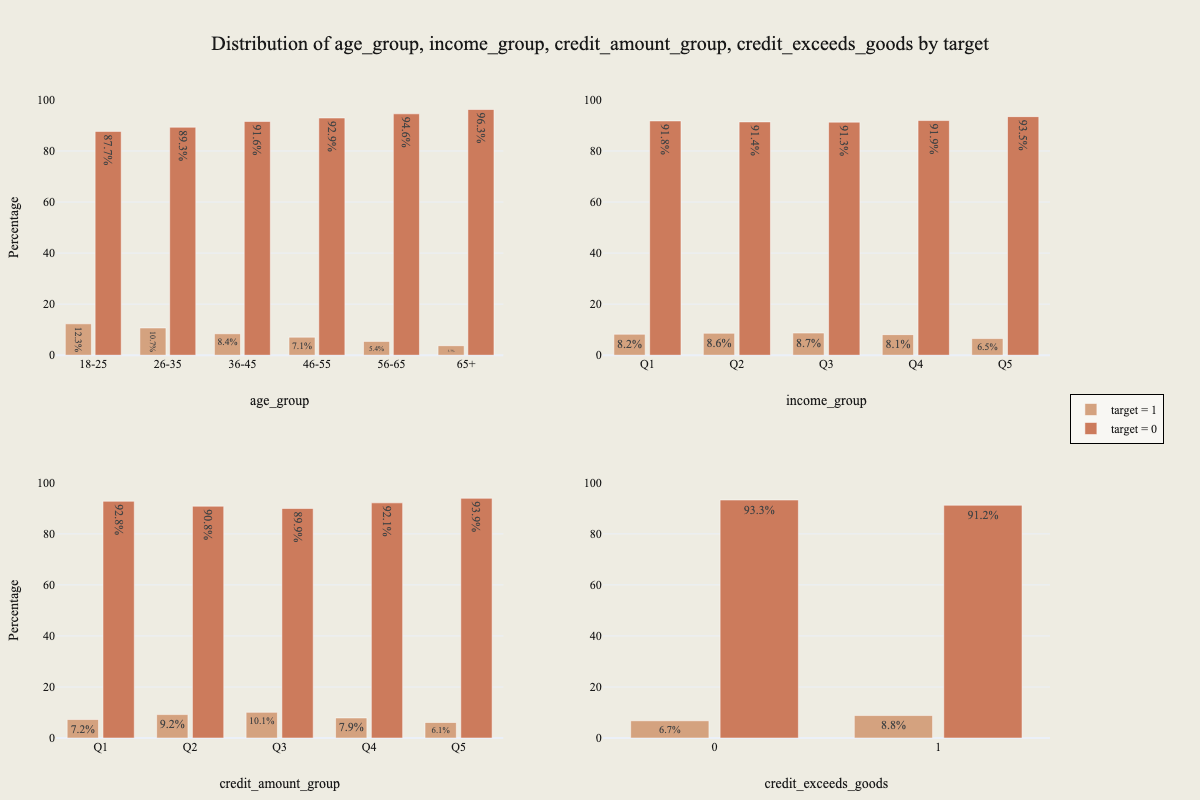

In [31]:
Image(filename="../images/categorical_features_engineered.png")

- **age_group:** The proportion of target=1 (likely loan defaults) generally decreases with age. The 18-25 group has the highest default rate, while the 65+ group has the lowest.

- **income_group:** There's a slight trend of decreasing default rates as income increases from Q1 to Q5, but the difference is not dramatic.

- **credit_amount_group:** Default rates are fairly consistent across credit amount groups, with a slight increase for middle ranges (Q2-Q4) compared to the extremes.

- **credit_exceeds_goods:** When credit exceeds goods value (1), the default rate is slightly higher (8.8%) compared to when it doesn't (6.7%).

Overall, these charts suggest that age and the relationship between credit amount and goods value have more pronounced effects on default rates than income or credit amount alone.


Finally, we will use the `encode_categorical_features` function to transform categorical variables into a numerical format suitable for machine learning.

This function will apply one-hot encoding to low-cardinality features, creating binary columns for each category and effectively handling unknown categories. For high-cardinality features, leave-one-out encoding will be used, replacing each category with the mean of the target variable.

This approach captures the relationship between the categories and the target.

The function ensures consistency between the training and testing datasets by aligning the encoded columns and removing any unwanted or constant columns.

This final encoding step prepares the data for model training by preserving valuable information while managing dimensionality.

In [32]:
application_train_encoded, application_test_encoded = (
    encode_categorical_features(
        application_train_engineered,
        application_test_engineered,
        ohe_features,
        target_encoded_features,
        ordinal_features,
        ordinal_orders,
        target_feature,
    )
)

1. **Binning Continuous Variables:** Transformed age, income, and credit amount into categorical bins to simplify models and handle outliers.
2. **Creating Derived Features:** Generated financial ratios and indicators to capture complex relationships and domain-specific insights.
3. **Encoding Categorical Variables:** Applied One-Hot and Leave-One-Out Encoding to convert categorical features into numerical formats suitable for modeling, ensuring consistency and effectively handling high-cardinality features.

These steps improve the dataset's quality and relevance for more accurate and robust machine learning models.

We will save the processed data to parquet files for efficient storage and retrieval.

Next, we'll move on to modeling in the `05_model_training_and_evaluation.ipynb` notebook.

In [33]:
application_train_encoded.to_parquet("../data/processed/application_train_engineered.parquet")
application_test_encoded.to_parquet("../data/processed/application_test_engineered.parquet")